# Model LSTM
Klasyfikuje jednosekudnowe wycinki pomiaru eeg na zamierające atak padaczki i nie zawierającego go. Odcinki składają się z 178 poamirów wykonanych w ciągu jedej sekundy.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from keras.layers import Input, LSTM
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

## Przygotowanie danych


In [2]:
data =pd.read_csv('data.csv')

Zostawiłem etykietę jedynie fragmentów przedstawiających atak padaczki. Resztę zamieniłem na zero.

In [3]:
data.y.replace([2,3,4,5],0, inplace = True)
data.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [24]:
nie = data.iloc[:,1:-1].iloc[0]
padaka = data.iloc[:,1:-1].iloc[1]

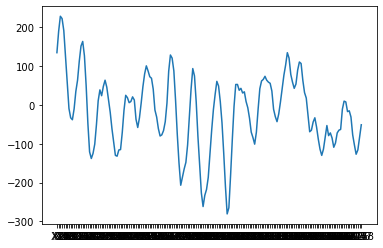

In [26]:
plt.plot(nie)
plt.show()

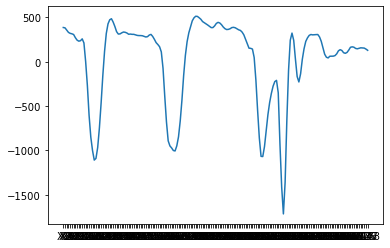

In [29]:
plt.plot(padaka)
plt.show()

Podzieliłem dataset na trzy różne:
  - df_train - na nim model będzie trenowany
  - df_valid - zbór walidacyjny
  - df_test - na nim będzie testowany

In [4]:
data_sampled = data.sample(n=len(data))
data_sampled = data_sampled.reset_index(drop=True)

In [5]:
df_valid_test = data_sampled.sample(frac=0.3)
print("Validation/Test Split Size: %.1f" % (len(df_valid_test) / len(data_sampled)))

df_test = df_valid_test.sample(frac=0.5)
df_valid = df_valid_test.drop(df_test.index)

df_train = data_sampled.drop(df_valid_test.index)

Validation/Test Split Size: 0.3


In [6]:
df_train.head(10)

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
3,X22.V1.692,120,117,112,108,94,77,60,50,37,...,-29,-64,-92,-109,-102,-98,-96,-101,-101,0
5,X10.V1.121,-111,-94,-79,-57,-22,11,25,26,11,...,-39,-52,-56,-84,-110,-126,-128,-121,-109,0
9,X22.V1.104,246,23,-138,-99,100,306,425,337,121,...,-175,-119,-63,-55,-15,219,337,486,419,1
11,X3.V1.591,95,36,-17,-46,-64,-46,-22,-35,-53,...,61,30,9,-1,-7,-16,7,55,87,0
12,X14.V1.182,57,52,47,43,49,65,78,88,90,...,-24,-23,-17,-9,4,-3,-3,-16,-22,0
15,X17.V1.943,-27,1,-8,9,20,44,44,39,29,...,106,85,76,74,83,74,60,47,44,0
16,X11.V1.851,-109,-104,-91,-95,-76,-45,-32,-42,-55,...,-34,-22,-8,-21,-56,-82,-111,-124,-96,0
17,X22.V1.844,258,307,327,303,242,187,148,124,109,...,-161,-21,69,119,126,126,146,183,228,1
18,X15.V1.210,34,52,58,59,58,46,17,-11,-40,...,47,38,33,32,35,39,41,26,24,0
19,X22.V1.453,9,25,38,42,48,44,42,38,14,...,54,33,10,-1,-6,1,12,19,42,0


In [7]:
print('Test data percentage of all data:' ,len(df_test)/len(data))
print('Validatation data percentage of all data:',len(df_valid)/len(data))
print('Train data percentage of all data:',len(df_train)/len(data))

Test data percentage of all data: 0.15
Validatation data percentage of all data: 0.15
Train data percentage of all data: 0.7


In [10]:
X_train = df_train.iloc[:,1:-1]
X_test = df_test.iloc[:,1:-1]
X_valid = df_valid.iloc[:,1:-1]
y_train = df_train.y
y_test = df_test.y
y_valid = df_valid.y

In [11]:
print('X_train shape',X_train.shape)
print('X_test shape',X_test.shape)
print('X_valid shape',X_valid.shape)

X_train shape (8050, 178)
X_test shape (1725, 178)
X_valid shape (1725, 178)


In [12]:
print('y_train shape',y_train.shape)
print('y_test shape',y_test.shape)
print('y_valid shape',y_valid.shape)

y_train shape (8050,)
y_test shape (1725,)
y_valid shape (1725,)


Zestandyryzowałem pomniary.

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std= scaler.transform(X_train)
X_test_std=scaler.transform(X_test)
X_valid_std=scaler.transform(X_valid)

In [14]:
print(X_train_std.shape[1])
print(X_test_std.shape[1])
print(X_valid_std.shape[1])

178
178
178


Przykład jedno sekundowego timestampu pomiaru eeg bez ataku padaczki.

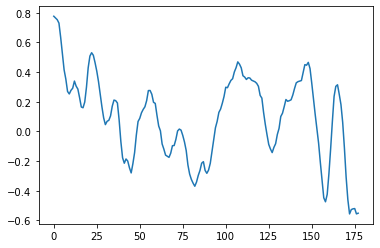

In [15]:
plt.plot(X_train_std[0])

plt.show()

Przykład jedno sekundowego timestampu pomiaru eeg ataku padaczki.

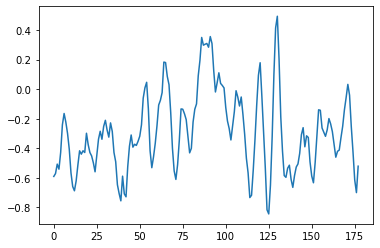

In [21]:
plt.plot(X_train_std[6])

plt.show()

## Model

In [15]:
def network_LSTM(x):
    im_shape=(x.shape[1],1)
    inputs_lstm=Input(shape=(im_shape), name='inputs_lstm')
    
    dense_1 = Dense(units=32, activation='relu', name='dense_1')(inputs_lstm)
    lstm = layers.Bidirectional(LSTM(units=128, name='lstm'))(dense_1)
    dropout_1 = Dropout(0.3, name='dropout_1')(lstm)
    batch_normalization = BatchNormalization(name='batch_normalization')(dropout_1)
    dense_2 = Dense(units=64, activation='relu', name='dense_2')(batch_normalization)
    dropout_2 = Dropout(0.3, name='dropout_2')(dense_2)
    batch_normalization_1 = BatchNormalization(name='batch_normalization_1')(dropout_2)
    main_output = Dense(units=1, activation='sigmoid')(batch_normalization_1)

    model = Model(inputs= inputs_lstm, outputs=main_output)
    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),metrics = ['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    
    return(model)

In [16]:
model = network_LSTM(X_train)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_lstm (InputLayer)     [(None, 178, 1)]          0         
_________________________________________________________________
dense_1 (Dense)              (None, 178, 32)           64        
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               164864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0     

In [17]:
history = model.fit(X_train,y_train,batch_size=5,epochs = 5,validation_data=(X_valid, y_valid))

Epoch 1/5
1610/1610 [==============================] - 129s 78ms/step - loss: 0.3554 - accuracy: 0.8478 - precision: 0.6267 - recall: 0.5582 - val_loss: 0.1746 - val_accuracy: 0.9380 - val_precision: 0.9596 - val_recall: 0.7311
Epoch 2/5
1610/1610 [==============================] - 126s 78ms/step - loss: 0.2979 - accuracy: 0.8788 - precision: 0.7299 - recall: 0.6081 - val_loss: 0.1539 - val_accuracy: 0.9426 - val_precision: 0.9479 - val_recall: 0.7647
Epoch 3/5
1610/1610 [==============================] - 128s 80ms/step - loss: 0.2889 - accuracy: 0.8831 - precision: 0.7434 - recall: 0.6188 - val_loss: 0.1332 - val_accuracy: 0.9507 - val_precision: 0.9416 - val_recall: 0.8123
Epoch 4/5
1610/1610 [==============================] - 131s 82ms/step - loss: 0.2540 - accuracy: 0.9050 - precision: 0.7980 - recall: 0.6915 - val_loss: 0.1321 - val_accuracy: 0.9501 - val_precision: 0.8613 - val_recall: 0.9048
Epoch 5/5
1610/1610 [==============================] - 131s 81ms/step - loss: 0.2323 - a

In [18]:
model.save('my_model.h5')

In [19]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

Accuracy: 94.32%


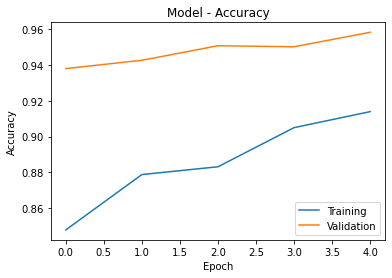

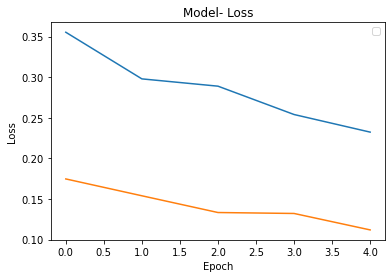

In [20]:
evaluate_model(history, X_test,y_test,model)

<AxesSubplot:>

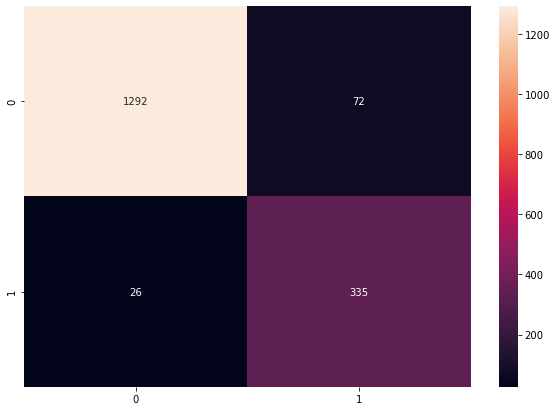

In [33]:
import seaborn as sns

predictions =np.round(model.predict(X_test))
cm  =confusion_matrix(y_test, predictions)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt ='g')

In [44]:
epochs = history.epoch

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

In [42]:
val_accuracy = history.history['val_accuracy']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']

In [60]:
val_accuracy

[0.9379709959030151,
 0.9426087141036987,
 0.9507246613502502,
 0.9501449465751648,
 0.9582608938217163]

In [61]:
val_precision

[0.9595588445663452,
 0.9479166865348816,
 0.9415584206581116,
 0.8613333106040955,
 0.8663238883018494]

In [62]:
val_recall

[0.7310924530029297,
 0.7647058963775635,
 0.8123249411582947,
 0.9047619104385376,
 0.9439775943756104]

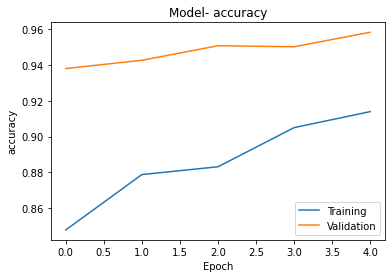

In [57]:
    fig, ax = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.title('Model- accuracy')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['accuracy'])
    plt.plot(val_accuracy)
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

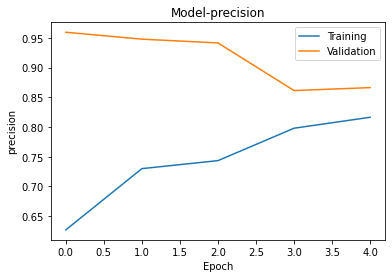

In [58]:
    fig, ax = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('precision')
    plt.title('Model-precision')
    plt.plot(history.history['precision'])
    plt.plot(val_precision)
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

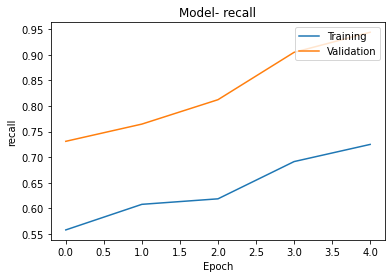

In [59]:
    fig, ax = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('recall')
    plt.title('Model- recall')
    plt.plot(history.history['recall'])
    plt.plot(val_recall)
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()